In [3]:
import numpy as np
import random
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

df = pd.read_csv('data/train_data.csv')
df = df.dropna().reset_index(drop=True)

c:\Users\Jessy\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [4]:
X_raw = df[['t0', 't1', 't2', 't3']].values 
Y_raw = df[['x', 'y']].values  

In [5]:
def create_narx_sequences(input_data, target_data, sequence_length=4, flatten=True):
    inputs = []
    targets = []
    data_size = len(input_data)
    
    for i in range(data_size-sequence_length):
        sequence = input_data[i:i+sequence_length]
        label_position = i + sequence_length
        label = target_data[label_position]
        if flatten:
            inputs.append(sequence.flatten())
        else:
            inputs.append(sequence)
        targets.append(label)
        
    return np.array(inputs), np.array(targets)

In [6]:
x, y = create_narx_sequences(X_raw, Y_raw, sequence_length=4, flatten=True)

In [7]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
import joblib

split_ratio = 0.25
split = int(len(x) * split_ratio)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=42)

input_scaler = StandardScaler()
X_train_norm = input_scaler.fit_transform(X_train)
X_test_norm = input_scaler.transform(X_test)

output_scaler = StandardScaler()
Y_train_norm = output_scaler.fit_transform(Y_train)
Y_test_norm = output_scaler.transform(Y_test)

np.save('data/X_test_norm.npy', X_test_norm)
np.save('data/Y_test_norm.npy', Y_test_norm)
np.save('data/Y_test.npy', Y_test)
joblib.dump(output_scaler, 'models/output_scaler.pkl')
joblib.dump(input_scaler, 'models/input_scaler.pkl')


# Convert to PyTorch tensors
X_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
Y_tensor = torch.tensor(Y_train_norm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test_norm, dtype=torch.float32)


input_size = X_tensor.shape[1]

In [40]:
from utils.ga import GeneticAlgorithm

# Run Genetic Algorithm
ga = GeneticAlgorithm(
    population_size=10,
    mutation_rate=0.3,
    crossover_rate=0.5,
    input_dim=input_size,
    X_tensor=X_tensor,
    Y_tensor=Y_tensor,
    tournament_size=3,
)

best_model = ga.run(generations=10000)
torch.save(best_model.state_dict(), 'models/best_ga_model.pth')

Generation 1, Best Fitness (MSE): 1.85389
Generation 2, Best Fitness (MSE): 1.73153
Generation 3, Best Fitness (MSE): 1.33196
Generation 4, Best Fitness (MSE): 1.33196
Generation 5, Best Fitness (MSE): 1.33196
Generation 6, Best Fitness (MSE): 1.33196
Generation 7, Best Fitness (MSE): 0.97427
Generation 8, Best Fitness (MSE): 0.88451
Generation 9, Best Fitness (MSE): 0.88451
Generation 10, Best Fitness (MSE): 0.78149
Generation 11, Best Fitness (MSE): 0.78149
Generation 12, Best Fitness (MSE): 0.78149
Generation 13, Best Fitness (MSE): 0.69951
Generation 14, Best Fitness (MSE): 0.61350
Generation 15, Best Fitness (MSE): 0.61350
Generation 16, Best Fitness (MSE): 0.61350
Generation 17, Best Fitness (MSE): 0.61350
Generation 18, Best Fitness (MSE): 0.61350
Generation 19, Best Fitness (MSE): 0.57543
Generation 20, Best Fitness (MSE): 0.57543
Generation 21, Best Fitness (MSE): 0.55535
Generation 22, Best Fitness (MSE): 0.55535
Generation 23, Best Fitness (MSE): 0.55535
Generation 24, Best 

In [41]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

with torch.no_grad():
    predictions = best_model(X_test_tensor).numpy()
    predictions_original = output_scaler.inverse_transform(predictions)
    Y_test_original = output_scaler.inverse_transform(Y_test_norm)

    preds_train_norm = best_model(X_tensor).numpy()
    preds_train = output_scaler.inverse_transform(preds_train_norm)
    Y_train_true = output_scaler.inverse_transform(Y_tensor.numpy())

# Evaluation
print("\nTrain set performance:")
print(f"MSE : {mean_squared_error(Y_train_true, preds_train):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_train_true, preds_train)):.5f}")
print(f"MAE : {mean_absolute_error(Y_train_true, preds_train):.5f}")
print(f"R^2 : {r2_score(Y_train_true, preds_train):.5f}")

print("\nEvaluation Metrics on Test Data:")
print(f"MSE : {mean_squared_error(Y_test_original, predictions_original):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test_original, predictions_original)):.5f}")
print(f"MAE : {mean_absolute_error(Y_test_original, predictions_original):.5f}")
print(f"R^2 : {r2_score(Y_test_original, predictions_original):.5f}")



Train set performance:
MSE : 0.00057
RMSE: 0.02397
MAE : 0.01722
R^2 : 0.91156

Evaluation Metrics on Test Data:
MSE : 0.00042
RMSE: 0.02051
MAE : 0.01599
R^2 : 0.92476


In [42]:
import torch
import numpy as np
import random
import joblib
import pandas as pd
from utils.narxwithga import NARXModel

# Load saved assets
X_test_norm = np.load("data/X_test_norm.npy")
Y_test_norm = np.load("data/Y_test_norm.npy")   # normalized
Y_test = np.load("data/Y_test.npy")             # unnormalized
output_scaler = joblib.load("models/output_scaler.pkl")
input_scaler = joblib.load("models/input_scaler.pkl")
input_dim = X_test_norm.shape[1]

# Load model
model = NARXModel(input_dim=input_dim, output_dim=2)
model.load_state_dict(torch.load("models/best_ga_model.pth"))
model.eval()

# Choose a random test index
rand_test_index = random.randint(0, len(X_test_norm) - 1)

# Prepare input tensor
input_tensor = torch.tensor(X_test_norm[rand_test_index:rand_test_index+1], dtype=torch.float32)
true_output = Y_test[rand_test_index]  # already unnormalized

# Predict
with torch.no_grad():
    pred_scaled = model(input_tensor).numpy()
    pred_original = output_scaler.inverse_transform(pred_scaled)

# Print prediction vs ground truth
print("\n--- Random Test Sample Evaluation ---")
print(f"Random Test Index: {rand_test_index}")
print(f"Predicted (x, y): {pred_original[0]}")
print(f"Ground Truth (x, y): {true_output}")



--- Random Test Sample Evaluation ---
Random Test Index: 6
Predicted (x, y): [ 0.11801287 -0.11157686]
Ground Truth (x, y): [ 0.11 -0.13]


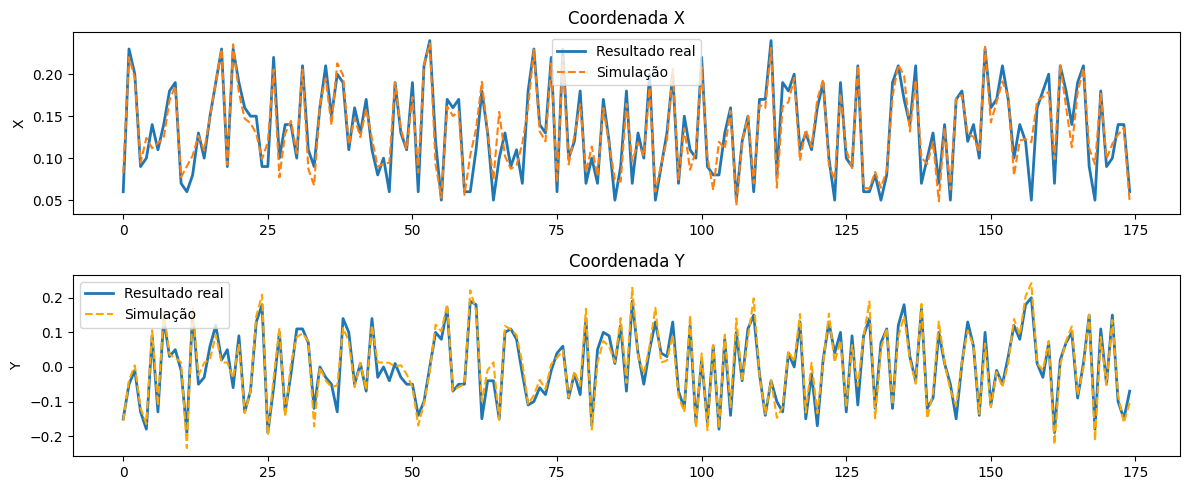

In [44]:
import matplotlib.pyplot as plt

X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
with torch.no_grad():
    all_preds_scaled = model(X_test_tensor).numpy()
    all_preds = output_scaler.inverse_transform(all_preds_scaled)

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(Y_test[:, 0], label='Resultado real', linewidth=2)
plt.plot(all_preds[:, 0], label='Simulação', linestyle='--')
plt.title('Coordenada X')
plt.ylabel('X')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Y_test[:, 1], label='Resultado real', linewidth=2)
plt.plot(all_preds[:, 1], label='Simulação', linestyle='--', color='orange')
plt.title('Coordenada Y')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()
